In [1]:
import pandas as pd
import glob
from pathlib import Path
import json
import numpy as np

In [2]:
pd.read_csv("../results/per_query_ir_results.csv")

,query,retriever,corpus,Hits@1,Hits@5,Hits@10,Hits@25,Accuracy@1,Accuracy@5,Accuracy@10,Accuracy@25
0,2d human pose estimation,bm25,dependency_signature,0.0,1.0,3.0,3.0,0.0,1.0,1.0,1.0
1,2d human pose estimation,bm25,generated_rationale,0.0,4.0,6.0,7.0,0.0,1.0,1.0,1.0
2,2d human pose estimation,bm25,generated_readme,0.0,3.0,5.0,7.0,0.0,1.0,1.0,1.0
3,2d human pose estimation,bm25,generated_tasks,0.0,1.0,1.0,3.0,0.0,1.0,1.0,1.0
4,2d human pose estimation,bm25,generation_context,0.0,0.0,1.0,2.0,0.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
22171,zero shot learning,word2vec,generated_tasks,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22172,zero shot learning,word2vec,generation_context,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22173,zero shot learning,word2vec,readme,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
22174,zero shot learning,word2vec,repository_signature,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [2]:
generation_metrics_df = pd.read_parquet("../output/signature_generation/librarian_signatures_generation_metrics.parquet")

In [3]:
def process_generation_metrics_df(generation_metrics_df):
    return (
        generation_metrics_df.assign(
            true_tasks=generation_metrics_df["true_tasks"].str.sp lit(", ").apply(tuple)
        ).groupby(["repo", "true_tasks"]).apply(lambda df: df.select_dtypes("float").mean())
    )

In [222]:
colorcodings = {
    "generated_tasks": "red", "repository_signature": "red", "dependency_signature": "red",
    "selected_code": "yellow",
    "generated_readme":"green", "generation_context": "green", "generated_rationale": "green",
    "generated_readme (repomap)":"cyan", "generation_context (repomap)": "cyan", "generated_rationale (repomap)": "cyan"}

def format_corpus_for_latex(corpus_name, intensity=25):
    
    if colorcodings.get(corpus_name) is None:
        return corpus_name
    else:
        color = colorcodings[corpus_name]
        corpus_name = corpus_name.replace("generation_context", "code summary")
        return f"\cellcolor{{{color}!{intensity}}} {corpus_name}"


def format_retriever_for_latex(retriever_name, intensity=25):
    if retriever_name == "bm25":
        retriever_name = f"\cellcolor{{blue!{intensity}}} {retriever_name}"
    elif retriever_name == "all-mpnet-base-v2 (sentence_transformer)":
        retriever_name = "st-MPNet"
    elif retriever_name == "all-MiniLM-L12-v2 (sentence_transformer)":
        retriever_name = "st-MiniLM"
    elif retriever_name == "Word2Vec":
        retriever_name = f"\cellcolor{{violet!{intensity}}} {retriever_name}"
    else:
        pass
    return retriever_name.replace("_", " ")

In [223]:
generation_metrics_df = process_generation_metrics_df(generation_metrics_df)

TypeError: 'float' object is not iterable

In [224]:
generation_metrics_df = generation_metrics_df.reset_index()

ValueError: cannot insert level_0, already exists

In [225]:
raw_ir_metrics_df = pd.read_csv("../output/code2doc/sample_per_task_5_repos/beir_results_codellama.csv")

In [226]:
repomap_ir_metrics_df = pd.read_csv("../output/code2doc/sample_per_task_5_repos/beir_results_codellama_repomaps.csv")
repomap_ir_metrics_df = repomap_ir_metrics_df[repomap_ir_metrics_df["corpus"].isin(["generated_readme", "generation_context", "generated_rationale"])]
repomap_ir_metrics_df["corpus"] = repomap_ir_metrics_df["corpus"] + " (repomap)"

In [227]:
ir_metrics_df = pd.concat([
    raw_ir_metrics_df,
    repomap_ir_metrics_df])

ir_metrics_df = ir_metrics_df[ir_metrics_df["retriever"] != "splade"]
#ir_metrics_df = ir_metrics_df.assign(
#    retriever=ir_metrics_df["retriever"].apply(format_retriever_for_latex),
#    corpus=ir_metrics_df["corpus"].apply(format_corpus_for_latex)
#)

In [228]:
def convert_df_to_latex_table(df, cols=["corpus", "retriever", "Accuracy@10", "Hits@10"], sort_values="Hits@10", column_format="|p{3cm}|p{2.5cm}|p{2cm}|p{2cm}|"):
    df = df.copy()
    if "retriever" in cols:
        df["retriever"] = df["retriever"].apply(format_retriever_for_latex)
    df["corpus"] = df["corpus"].apply(format_corpus_for_latex)
    return (
        df[
            cols
        ].sort_values(sort_values, ascending=False)
        .to_latex(index_names=False, index=False, column_format=column_format, float_format="%.3f")
        .replace("%", "\%").replace("_", " ").strip().replace("\n", "\n\hline\n")
    )

In [229]:
ir_metrics_best_retriever_df = ir_metrics_df.sort_values("Hits@10", ascending=False).drop_duplicates(subset=["corpus"])

In [230]:
basic_corpora = ["readme", "dependency_signature", "selected_code"]
basic_ir_metrics_best_retriever_df = ir_metrics_best_retriever_df[ir_metrics_best_retriever_df["corpus"].isin(basic_corpora)]

## Basic corpora

In [231]:
print(convert_df_to_latex_table(basic_ir_metrics_best_retriever_df))

\begin{tabular}{|p{3cm}|p{2.5cm}|p{2cm}|p{2cm}|}
\hline
\toprule
\hline
corpus & retriever & Accuracy@10 & Hits@10 \\
\hline
\midrule
\hline
readme & \cellcolor{blue!25} bm25 & 0.911 & 4.122 \\
\hline
\cellcolor{red!25} dependency signature & st-MPNet & 0.716 & 1.912 \\
\hline
\cellcolor{yellow!25} selected code & \cellcolor{blue!25} bm25 & 0.682 & 1.818 \\
\hline
\bottomrule
\hline
\end{tabular}


## Signature corpora

In [232]:
signature_ir_metrics_best_retriever_df = ir_metrics_best_retriever_df[ir_metrics_best_retriever_df["corpus"].isin(basic_corpora + ["repository_signature", "generated_tasks"])]

In [233]:
print(convert_df_to_latex_table(signature_ir_metrics_best_retriever_df))

\begin{tabular}{|p{3cm}|p{2.5cm}|p{2cm}|p{2cm}|}
\hline
\toprule
\hline
corpus & retriever & Accuracy@10 & Hits@10 \\
\hline
\midrule
\hline
readme & \cellcolor{blue!25} bm25 & 0.911 & 4.122 \\
\hline
\cellcolor{red!25} repository signature & st-MPNet & 0.734 & 2.031 \\
\hline
\cellcolor{red!25} dependency signature & st-MPNet & 0.716 & 1.912 \\
\hline
\cellcolor{yellow!25} selected code & \cellcolor{blue!25} bm25 & 0.682 & 1.818 \\
\hline
\cellcolor{red!25} generated tasks & st-MiniLM & 0.681 & 1.681 \\
\hline
\bottomrule
\hline
\end{tabular}


## Code2doc 

In [212]:
code2doc_corpora = ["readme"]
for cname in ["generated_readme", "generated_rationale", "generation_context"]:
    code2doc_corpora.append(cname)
    code2doc_corpora.append(cname + " (repomap)")

code2doc_ir_metrics_best_retriever_df = ir_metrics_best_retriever_df[ir_metrics_best_retriever_df["corpus"].isin(code2doc_corpora)]

In [213]:
print(convert_df_to_latex_table(code2doc_ir_metrics_best_retriever_df))

\begin{tabular}{|p{3cm}|p{2.5cm}|p{2cm}|p{2cm}|}
\hline
\toprule
\hline
corpus & retriever & Accuracy@10 & Hits@10 \\
\hline
\midrule
\hline
readme & \cellcolor{blue!25} bm25 & 0.911 & 4.122 \\
\hline
\cellcolor{green!25} generated readme & st-MPNet & 0.836 & 2.675 \\
\hline
\cellcolor{green!25} generated rationale & st-MPNet & 0.813 & 2.615 \\
\hline
\cellcolor{cyan!25} generated readme (repomap) & st-MPNet & 0.785 & 2.462 \\
\hline
\cellcolor{cyan!25} generated rationale (repomap) & st-MPNet & 0.797 & 2.442 \\
\hline
\cellcolor{green!25} code summary & st-MPNet & 0.794 & 2.318 \\
\hline
\cellcolor{cyan!25} code summary (repomap) & st-MiniLM & 0.659 & 1.665 \\
\hline
\bottomrule
\hline
\end{tabular}


## Best retriever

In [218]:
print(convert_df_to_latex_table(ir_metrics_best_retriever_df))

\begin{tabular}{|p{3cm}|p{2.5cm}|p{2cm}|p{2cm}|}
\hline
\toprule
\hline
corpus & retriever & Accuracy@10 & Hits@10 \\
\hline
\midrule
\hline
readme & \cellcolor{blue!25} bm25 & 0.911 & 4.122 \\
\hline
\cellcolor{green!25} generated readme & st-MPNet & 0.836 & 2.675 \\
\hline
\cellcolor{green!25} generated rationale & st-MPNet & 0.813 & 2.615 \\
\hline
\cellcolor{cyan!25} generated readme (repomap) & st-MPNet & 0.785 & 2.462 \\
\hline
\cellcolor{cyan!25} generated rationale (repomap) & st-MPNet & 0.797 & 2.442 \\
\hline
\cellcolor{green!25} code summary & st-MPNet & 0.794 & 2.318 \\
\hline
\cellcolor{red!25} repository signature & st-MPNet & 0.734 & 2.031 \\
\hline
\cellcolor{red!25} dependency signature & st-MPNet & 0.716 & 1.912 \\
\hline
\cellcolor{yellow!25} selected code & \cellcolor{blue!25} bm25 & 0.682 & 1.818 \\
\hline
\cellcolor{red!25} generated tasks & st-MiniLM & 0.681 & 1.681 \\
\hline
\cellcolor{cyan!25} code summary (repomap) & st-MiniLM & 0.659 & 1.665 \\
\hline
\bottom

## Average over retrievers

In [219]:
ir_metrics_avg_retriever_df = ir_metrics_df.sort_values("Hits@10", ascending=False).drop(columns=["retriever"]).groupby("corpus").agg("mean").reset_index()

In [220]:
print(convert_df_to_latex_table(ir_metrics_avg_retriever_df,  cols=["corpus", "Accuracy@10", "Hits@10"], sort_values="Hits@10", column_format="|p{3cm}|p{2cm}|p{2cm}|"))

\begin{tabular}{|p{3cm}|p{2cm}|p{2cm}|}
\hline
\toprule
\hline
corpus & Accuracy@10 & Hits@10 \\
\hline
\midrule
\hline
readme & 0.807 & 3.095 \\
\hline
\cellcolor{green!25} generated readme & 0.729 & 2.117 \\
\hline
\cellcolor{green!25} generated rationale & 0.704 & 1.994 \\
\hline
\cellcolor{cyan!25} generated rationale (repomap) & 0.704 & 1.935 \\
\hline
\cellcolor{cyan!25} generated readme (repomap) & 0.700 & 1.933 \\
\hline
\cellcolor{green!25} code summary & 0.648 & 1.646 \\
\hline
\cellcolor{red!25} repository signature & 0.606 & 1.398 \\
\hline
\cellcolor{red!25} generated tasks & 0.598 & 1.355 \\
\hline
\cellcolor{cyan!25} code summary (repomap) & 0.540 & 1.255 \\
\hline
\cellcolor{yellow!25} selected code & 0.531 & 1.219 \\
\hline
\cellcolor{red!25} dependency signature & 0.507 & 1.148 \\
\hline
\bottomrule
\hline
\end{tabular}


In [200]:
per_query_metrics_df = pd.read_csv("../results/per_query_ir_results.csv").fillna(0.0)
per_query_metrics_df.columns = [c.lower() for c in per_query_metrics_df.columns]

In [9]:
per_query_metrics_df

,query,retriever,corpus,hits@1,hits@5,hits@10,hits@25,accuracy@1,accuracy@5,accuracy@10,accuracy@25
0,2d human pose estimation,bm25,dependency_signature,1.000000,2.0,4.000000,4.000000,1.000000,1.0,1.000000,1.000000
1,2d human pose estimation,bm25,generated_rationale,0.000000,1.0,2.000000,4.000000,0.000000,1.0,1.000000,1.000000
2,2d human pose estimation,bm25,generated_readme,0.000000,1.0,1.000000,2.000000,0.000000,1.0,1.000000,1.000000
3,2d human pose estimation,bm25,generated_tasks,0.333333,2.0,3.333333,5.000000,0.333333,1.0,1.000000,1.000000
4,2d human pose estimation,bm25,generation_context,0.000000,0.0,1.000000,4.000000,0.000000,0.0,1.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...
32875,zero shot learning,word2vec,generated_tasks,0.000000,0.0,0.333333,1.000000,0.000000,0.0,0.333333,0.666667
32876,zero shot learning,word2vec,generation_context,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
32877,zero shot learning,word2vec,readme,1.000000,1.0,1.000000,1.000000,1.000000,1.0,1.000000,1.000000
32878,zero shot learning,word2vec,repository_signature,0.000000,0.0,0.000000,0.333333,0.000000,0.0,0.000000,0.333333


In [10]:
generation_metrics_df["true_tasks"].explode().value_counts()

true_tasks
general classification            4401
object detection                  2988
image classification              2959
semantic segmentation             2864
translation                       2385
                                  ... 
copy detection                       1
empathetic response generation       1
multi view subspace clustering       1
link property prediction             1
voice anti spoofing                  1
Name: count, Length: 1238, dtype: int64

In [11]:
#generation_metrics_df["true_tasks"] = generation_metrics_df["true_tasks"].str.replace("'", '"').apply(json.loads)

In [12]:
generation_metrics_df

,repo,true_tasks,bertscore_precision,bertscore_recall,bertscore_f1,rouge1,rouge2,rougeL,rougeLsum,wmd,sentence_transformer_similarity
0,000Justin000/torchdiffeq,"(multivariate time series forecasting, point p...",0.806660,0.814494,0.810345,0.000000,0.000000,0.000000,0.000000,1.170770,0.264640
1,008karan/SincNet_demo,"(speaker recognition, speaker identification, ...",0.875573,0.892146,0.883747,0.160428,0.074074,0.160428,0.160428,0.839184,0.469539
2,011235813/SEPT,"(variational inference, reinforcement learning)",0.859547,0.847597,0.853403,0.000000,0.000000,0.000000,0.000000,1.059260,0.315521
3,011235813/cm3,"(efficient exploration, autonomous vehicles, m...",0.899083,0.872275,0.885467,0.317460,0.158120,0.317460,0.317460,0.666679,0.604338
4,011235813/hierarchical-marl,"(q learning, multi agent reinforcement learnin...",0.882972,0.888876,0.885716,0.400000,0.259615,0.400000,0.400000,0.775719,0.630357
...,...,...,...,...,...,...,...,...,...,...,...
34242,zzzace2000/FIDO-saliency,"(image classification,)",0.806788,0.857974,0.831552,0.111111,0.000000,0.111111,0.111111,0.952304,0.304501
34243,zzzace2000/autodiagnosis,"(mortality prediction, reinforcement learning)",0.849194,0.863487,0.856261,0.051282,0.000000,0.051282,0.051282,1.040992,0.421359
34244,zzzace2000/dropout-feature-ranking,"(time series,)",0.776531,0.838860,0.806417,0.000000,0.000000,0.000000,0.000000,1.191111,0.133118
34245,zzzace2000/mimic-preprocess,"(time series, length of stay prediction, gener...",0.859393,0.840186,0.849666,0.066667,0.037037,0.066667,0.066667,1.002234,0.389563


In [13]:
generation_metrics_df["true_tasks"]

0        (multivariate time series forecasting, point p...
1        (speaker recognition, speaker identification, ...
2          (variational inference, reinforcement learning)
3        (efficient exploration, autonomous vehicles, m...
4        (q learning, multi agent reinforcement learnin...
                               ...                        
34242                              (image classification,)
34243       (mortality prediction, reinforcement learning)
34244                                       (time series,)
34245    (time series, length of stay prediction, gener...
34246                                      (quantization,)
Name: true_tasks, Length: 34247, dtype: object

In [14]:
generation_metric_names = [
 'rouge1',
 'rouge2',
 'rougeL',
 'rougeLsum',
 'sentence_transformer_similarity',
 'wmd']

In [15]:
per_query_generation_metrics_df = (
    generation_metrics_df
        .explode("true_tasks")
        .rename(columns={"true_tasks": "task"})
        .groupby("task")
        [generation_metric_names]
        .agg("mean")
)

In [16]:
per_query_metrics_df.head()

,query,retriever,corpus,hits@1,hits@5,hits@10,hits@25,accuracy@1,accuracy@5,accuracy@10,accuracy@25
0,2d human pose estimation,bm25,dependency_signature,1.000000,2.0,4.000000,4.0,1.000000,1.0,1.0,1.0
1,2d human pose estimation,bm25,generated_rationale,0.000000,1.0,2.000000,4.0,0.000000,1.0,1.0,1.0
2,2d human pose estimation,bm25,generated_readme,0.000000,1.0,1.000000,2.0,0.000000,1.0,1.0,1.0
3,2d human pose estimation,bm25,generated_tasks,0.333333,2.0,3.333333,5.0,0.333333,1.0,1.0,1.0
4,2d human pose estimation,bm25,generation_context,0.000000,0.0,1.000000,4.0,0.000000,0.0,1.0,1.0


In [17]:
per_query_generation_metrics_df.shape

(1238, 6)

In [18]:
retriever_name = "bm25"
corpus_name = "readme"


In [19]:
per_query_metrics_df["retriever"].unique()

array(['bm25',
       'flax-sentence-embeddings/st-codesearch-distilroberta-base',
       'sentence-transformers/all-MiniLM-L12-v2',
       'sentence-transformers/all-mpnet-base-v2', 'word2vec'],
      dtype=object)

In [20]:
checked_corpora = [
    'generated_readme',
       'dependency_signature', 'repository_signature', 'generated_tasks'
]

checked_retrievers = ['bm25', 'sentence-transformers/all-mpnet-base-v2',
       'sentence-transformers/all-MiniLM-L12-v2',
       #'flax-sentence-embeddings/st-codesearch-distilroberta-base'
]


In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

In [22]:
shown_generation_metrics = ["rougeL"]#, "sentence_transformer_similarity"]


def get_worst_queries(df, q=0.1, metrics=shown_generation_metrics):
    is_lowest = (df[metrics] < df[metrics].quantile(q)).min(axis=1) > 0
    return df[is_lowest].index

In [23]:
worst_queries = get_worst_queries(per_query_generation_metrics_df, q=0.1)

In [24]:
len(worst_queries)

124

In [25]:
per_query_generation_metrics_df["rougeL"].quantile(0.2)

0.06502474733287476

In [26]:
per_query_metrics_df["query"]

0        2d human pose estimation
1        2d human pose estimation
2        2d human pose estimation
3        2d human pose estimation
4        2d human pose estimation
                   ...           
32875          zero shot learning
32876          zero shot learning
32877          zero shot learning
32878          zero shot learning
32879          zero shot learning
Name: query, Length: 32880, dtype: object

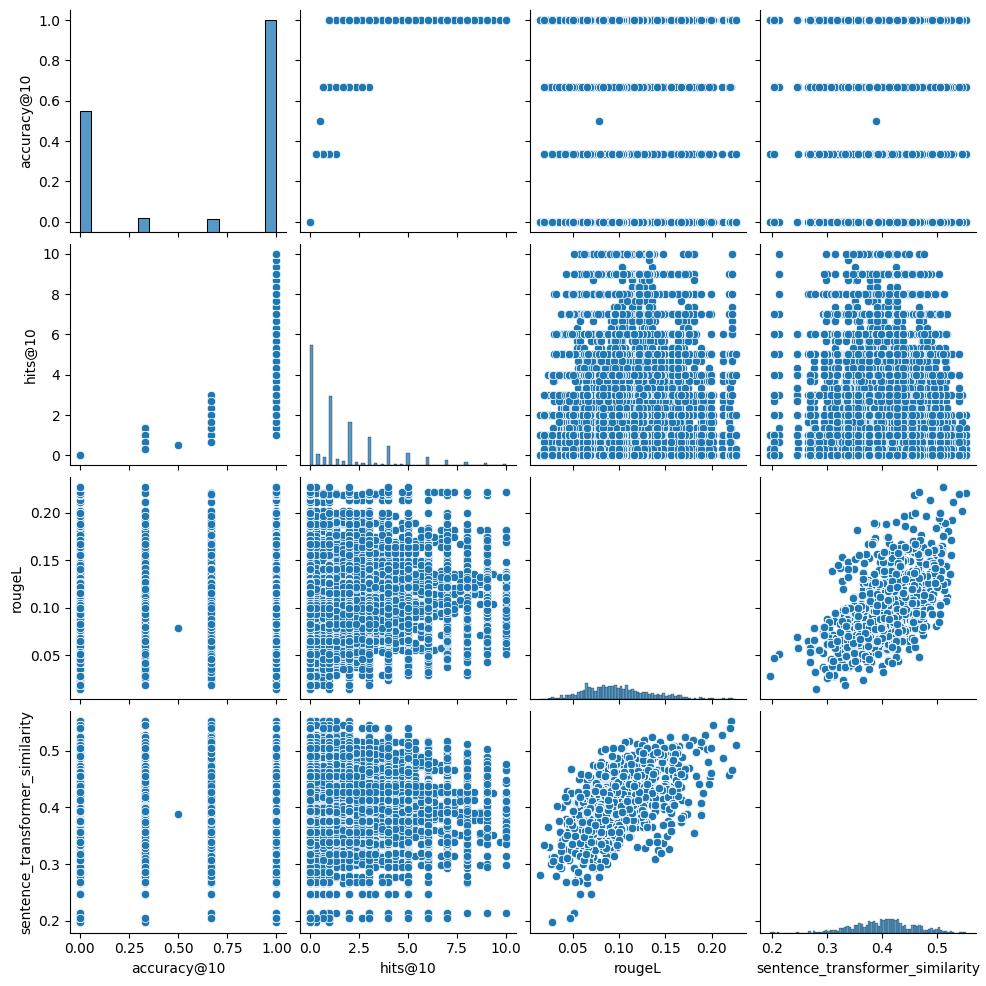

In [27]:
sns.pairplot(per_query_metrics_df.merge(per_query_generation_metrics_df, left_on="query", right_index=True)[["accuracy@10", "hits@10", "rougeL", "sentence_transformer_similarity"]])

In [28]:
worst_queries.shape

(124,)

generated_readme bm25


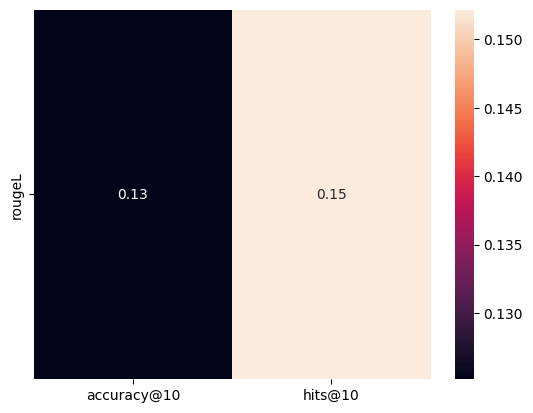

generated_readme sentence-transformers/all-mpnet-base-v2


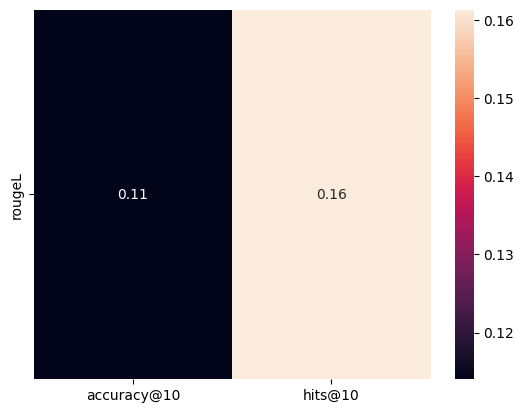

generated_readme sentence-transformers/all-MiniLM-L12-v2


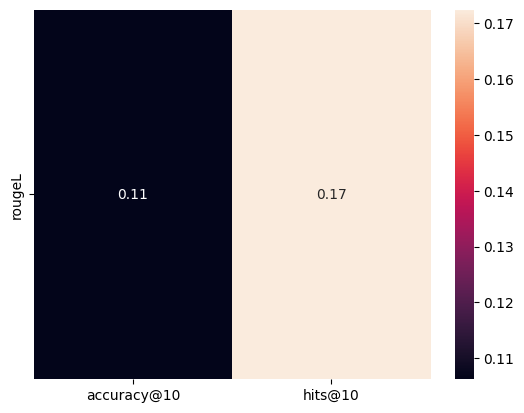

dependency_signature bm25


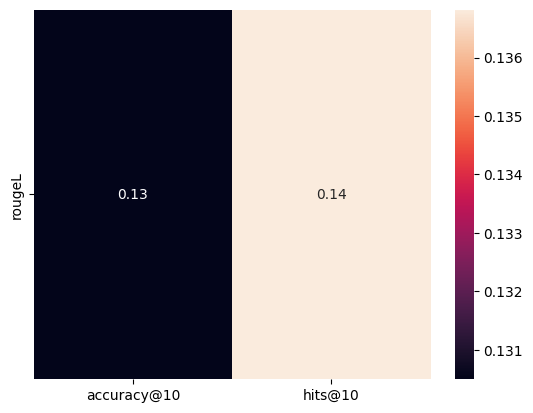

dependency_signature sentence-transformers/all-mpnet-base-v2


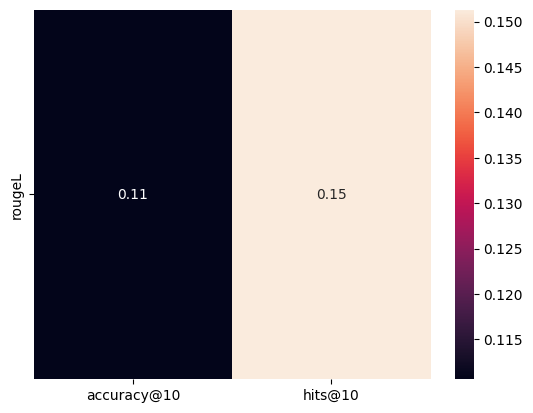

dependency_signature sentence-transformers/all-MiniLM-L12-v2


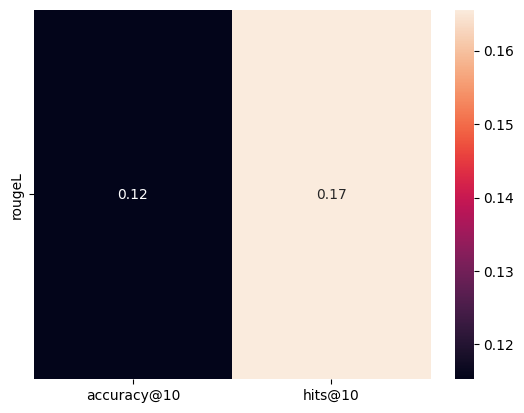

repository_signature bm25


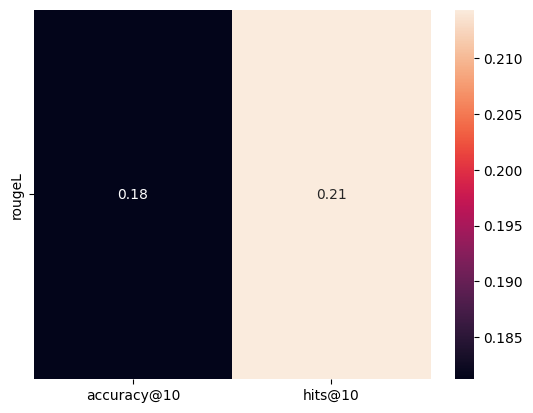

repository_signature sentence-transformers/all-mpnet-base-v2


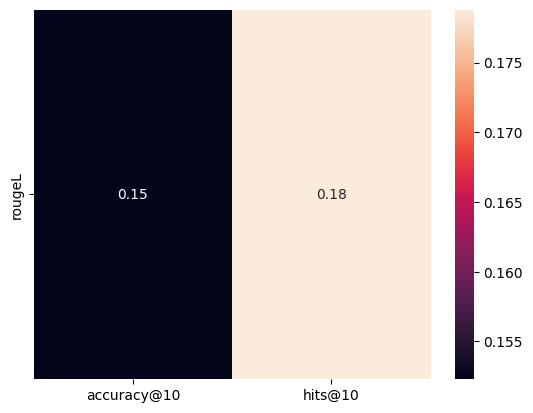

repository_signature sentence-transformers/all-MiniLM-L12-v2


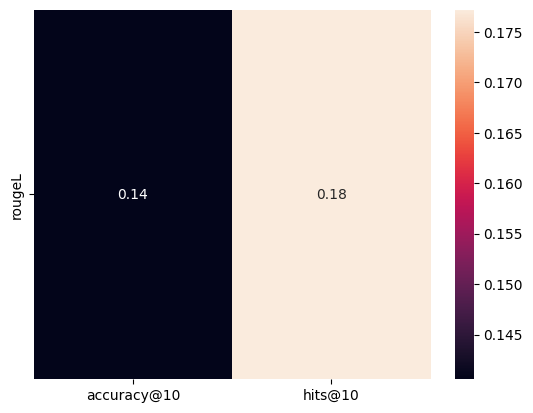

generated_tasks bm25


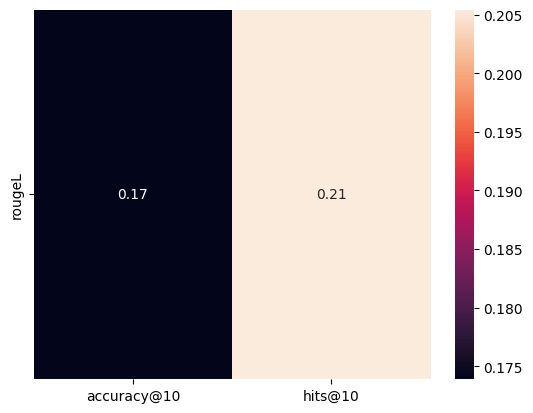

generated_tasks sentence-transformers/all-mpnet-base-v2


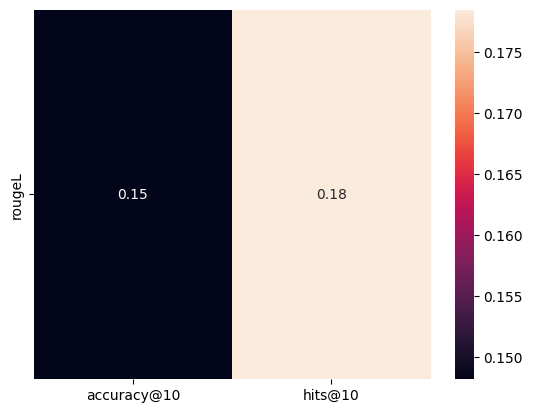

generated_tasks sentence-transformers/all-MiniLM-L12-v2


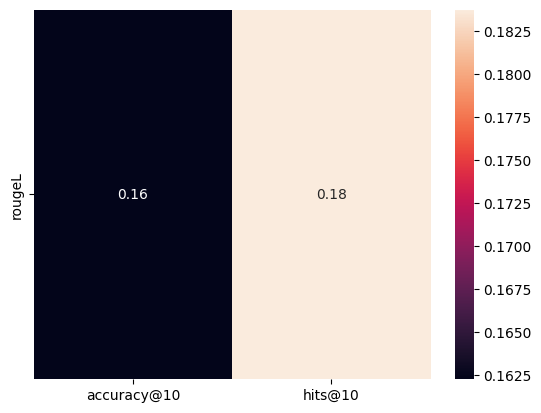

In [29]:
generation_vs_ir_kendall_dfs = []

for corpus_name in checked_corpora:
    for retriever_name in checked_retrievers:
        print(corpus_name, retriever_name)
        selected_metrics_df = per_query_metrics_df[
            (per_query_metrics_df["retriever"] == retriever_name) &
            (per_query_metrics_df["corpus"] == corpus_name)
        ][["query", "accuracy@10", "hits@10"]] 
        #worst_queries_df = per_query_generation_metrics_df.loc[worst_queries]
        corr_df = (
            selected_metrics_df
                .merge(per_query_generation_metrics_df, left_on="query", right_on="task")
                .select_dtypes("float")
                .corr(method="kendall").loc[shown_generation_metrics, ["accuracy@10", "hits@10"]]
        )
        sns.heatmap(corr_df, annot=True)
        plt.show()
        corr_df["retriever"] = [retriever_name]
        corr_df["corpus"] = [corpus_name]
        generation_vs_ir_kendall_dfs.append(corr_df[["corpus", "retriever", "accuracy@10", "hits@10"]])

generation_vs_ir_kendall_df = pd.concat(generation_vs_ir_kendall_dfs)

In [30]:
def corr_df_to_latex(generation_vs_ir_kendall_df):
    generation_vs_ir_kendall_df = generation_vs_ir_kendall_df.copy()
    generation_vs_ir_kendall_df["corpus"] = generation_vs_ir_kendall_df["corpus"].apply(colorcode)
    #generation_vs_ir_kendall_df["retriever"] = (
    #    generation_vs_ir_kendall_df["retriever"]
    #        .str.replace("sentence-transformers/all-mpnet-base-v2", "st-MPNet")
    #        .str.replace("sentence-transformers/all-MiniLM-L12-v2", "st-MiniLM")
    #)

    return (
        generation_vs_ir_kendall_df
            .sort_values("hits@10")
            .to_latex(index_names=False, index=False, column_format="|p{3cm}|p{2.5cm}|p{2cm}|p{2cm}|", float_format="%.2f")
            .replace("%", "\%").replace("_", " ").strip().replace("\n", "\n\hline\n")
    )

In [31]:
print(corr_df_to_latex(generation_vs_ir_kendall_df.drop(columns=["retriever"]).groupby("corpus").agg("mean").sort_values("hits@10").reset_index()))

\begin{tabular}{|p{3cm}|p{2.5cm}|p{2cm}|p{2cm}|}
\hline
\toprule
\hline
corpus & accuracy@10 & hits@10 \\
\hline
\midrule
\hline
\cellcolor{red!50} dependency signature & 0.12 & 0.15 \\
\hline
\cellcolor{green!50} generated readme & 0.12 & 0.16 \\
\hline
\cellcolor{red!50} generated tasks & 0.16 & 0.19 \\
\hline
\cellcolor{red!50} repository signature & 0.16 & 0.19 \\
\hline
\bottomrule
\hline
\end{tabular}


In [32]:
generation_vs_ir_kendall_df

,corpus,retriever,accuracy@10,hits@10
rougeL,generated_readme,bm25,0.125152,0.152165
rougeL,generated_readme,sentence-transformers/all-mpnet-base-v2,0.114030,0.161285
rougeL,generated_readme,sentence-transformers/all-MiniLM-L12-v2,0.106250,0.172395
rougeL,dependency_signature,bm25,0.130494,0.136819
rougeL,dependency_signature,sentence-transformers/all-mpnet-base-v2,0.110613,0.151310
rougeL,dependency_signature,sentence-transformers/all-MiniLM-L12-v2,0.115265,0.165567
rougeL,repository_signature,bm25,0.181219,0.214343
rougeL,repository_signature,sentence-transformers/all-mpnet-base-v2,0.152284,0.178801
rougeL,repository_signature,sentence-transformers/all-MiniLM-L12-v2,0.140574,0.177185
rougeL,generated_tasks,bm25,0.173880,0.205414


In [33]:
def get_metric_diffs(per_query_metrics_df, worst_queries):
    dfs = []
    for name, gp_df in per_query_metrics_df.groupby(["corpus", "retriever"]):
        selected_df = gp_df[gp_df["query"].isin(worst_queries)]
        selected_metrics_df = selected_df[["hits@10", "accuracy@10"]].mean()
        all_metrics_df = gp_df[["hits@10", "accuracy@10"]].mean()
        exp_difference_df = (all_metrics_df - selected_metrics_df)
        diffs = pd.concat([all_metrics_df, selected_metrics_df, exp_difference_df, 100 * (exp_difference_df / all_metrics_df)])
        diffs.index = ["hits@10", "accuracy@10", "worst records hits@10", "worst records accuracy@10", "hits@10 difference", "accuracy@10 difference", "% hits@10 difference", "% accuracy@10 difference"]
        diffs = pd.concat([pd.Series(dict(zip(["corpus", "retriever"], name))), diffs])
        dfs.append(diffs)
    return pd.concat(dfs, axis=1).T

In [34]:
def prettify_diffs_df(diff_df):
    for col in diff_df.columns:
        if "%" in col:
            diff_df[col] = diff_df[col].apply(lambda x: np.round(x,1)).astype(str) + "%"
        else:
            diff_df[col] = diff_df[col].apply(lambda x: np.round(x,3))
    return diff_df

In [35]:
diffs_df = get_metric_diffs(per_query_metrics_df, worst_queries)

In [36]:
aggregated_diffs_df = prettify_diffs_df(diffs_df.drop(columns="retriever").groupby("corpus").agg("mean").sort_values("% hits@10 difference", ascending=False))

In [37]:
per_query_metrics_df[per_query_metrics_df["query"].isin(worst_queries)].describe()[["hits@10", "accuracy@10"]]

,hits@10,accuracy@10
count,2000.000000,2000.000000
mean,0.880000,0.449500
std,1.369827,0.482251
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,1.000000,1.000000
max,9.000000,1.000000


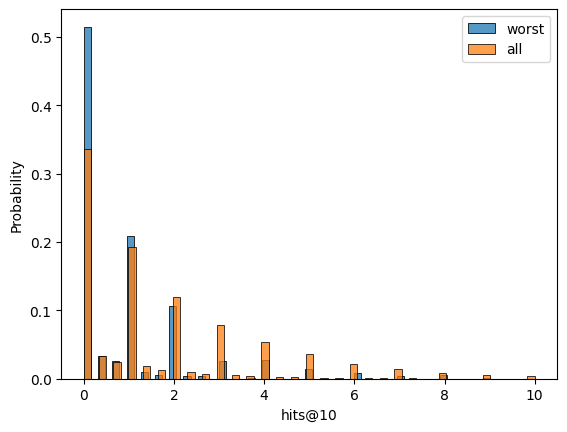

In [38]:
sns.histplot(per_query_metrics_df[per_query_metrics_df["query"].isin(worst_queries)]["hits@10"], kde=False, stat="probability", label="worst")
sns.histplot(per_query_metrics_df["hits@10"], kde=False, stat="probability", label="all")
plt.legend()
plt.savefig("/home/kuba/Downloads/worst_tasks_hits.png")

The following results show mean hits and accuracy@10 and the difference between these metrics for worst 10% queries as measured by generation metrics.

We investigate these differences further with Mann-Whitney test. The null hypothesis is $H_0: X_{worst} \not< X_{rest}$, that is, hits for the worst queries are not less than for the other queries. Assuming significance level of 0.01 we can refute $H_0$ for all corpora except original READMEs.

In [39]:



def make_displayed_agg_diffs_df(diffs_df, metric="accuracy"):
    displayed_df = aggregated_diffs_df[[col for col in aggregated_diffs_df.columns if metric in col]].copy()
    displayed_df[f"{metric}@10 difference"] = displayed_df[f"{metric}@10 difference"].apply(str) + " (" + displayed_df[f"% {metric}@10 difference"] + ")"
    displayed_df = displayed_df.drop("readme").reset_index()
    displayed_df["corpus"] = displayed_df["corpus"].apply(colorcode)
    latex_str = (
        displayed_df
            .drop(columns=[f"% {metric}@10 difference"])
            .to_latex(index_names=False, index=False, column_format="|p{3cm}|p{2.5cm}|p{2cm}|p{2cm}|", float_format="%.3f")
    )
    return latex_str.replace("%", "\%").replace("_", " ").strip().replace("\n", "\n\hline\n")

In [40]:
aggregated_diffs_df

,hits@10,accuracy@10,worst records hits@10,worst records accuracy@10,hits@10 difference,accuracy@10 difference,% hits@10 difference,% accuracy@10 difference
corpus,,,,,,,,
generated_tasks,1.339,0.607,0.517,0.332,0.822,0.275,63.3%,46.6%
repository_signature,1.402,0.606,0.583,0.360,0.819,0.246,61.5%,43.2%
generated_readme,1.932,0.699,0.820,0.508,1.112,0.191,59.5%,28.9%
generated_rationale,1.934,0.704,0.864,0.540,1.070,0.164,56.4%,24.3%
generation_context,1.254,0.540,0.628,0.396,0.626,0.144,53.9%,31.2%
dependency_signature,1.154,0.510,0.548,0.360,0.606,0.150,49.9%,30.8%
selected_code,1.222,0.533,0.796,0.392,0.426,0.141,38.0%,25.9%
readme,3.092,0.806,2.284,0.708,0.808,0.098,30.7%,14.0%


In [39]:
aggregated_diffs_df

,hits@10,accuracy@10,worst records hits@10,worst records accuracy@10,hits@10 difference,accuracy@10 difference,% hits@10 difference,% accuracy@10 difference
corpus,,,,,,,,
generated_tasks,1.334,0.606,0.520,0.335,0.814,0.272,62.9%,46.2%
generation_context,1.645,0.648,0.688,0.452,0.957,0.196,61.5%,34.5%
repository_signature,1.397,0.605,0.583,0.361,0.815,0.243,61.3%,42.8%
generated_readme,2.116,0.729,0.900,0.532,1.216,0.197,59.5%,28.6%
generated_rationale,1.992,0.704,0.888,0.492,1.104,0.212,57.5%,31.8%
dependency_signature,1.147,0.507,0.548,0.360,0.599,0.147,49.3%,30.2%
selected_code,1.217,0.531,0.788,0.392,0.429,0.139,38.1%,25.7%
readme,3.093,0.807,2.292,0.712,0.801,0.095,30.4%,13.6%


In [40]:
print(make_displayed_agg_diffs_df(aggregated_diffs_df))

\begin{tabular}{|p{3cm}|p{2.5cm}|p{2cm}|p{2cm}|}
\hline
\toprule
\hline
corpus & accuracy@10 & worst records accuracy@10 & accuracy@10 difference \\
\hline
\midrule
\hline
\cellcolor{red!50} generated tasks & 0.606 & 0.335 & 0.272 (46.2\%) \\
\hline
\cellcolor{green!50} generation context & 0.648 & 0.452 & 0.196 (34.5\%) \\
\hline
\cellcolor{red!50} repository signature & 0.605 & 0.361 & 0.243 (42.8\%) \\
\hline
\cellcolor{green!50} generated readme & 0.729 & 0.532 & 0.197 (28.6\%) \\
\hline
\cellcolor{green!50} generated rationale & 0.704 & 0.492 & 0.212 (31.8\%) \\
\hline
\cellcolor{red!50} dependency signature & 0.507 & 0.360 & 0.147 (30.2\%) \\
\hline
\cellcolor{yellow!50} selected code & 0.531 & 0.392 & 0.139 (25.7\%) \\
\hline
\bottomrule
\hline
\end{tabular}


In [41]:
print(make_displayed_agg_diffs_df(aggregated_diffs_df, "hits"))

\begin{tabular}{|p{3cm}|p{2.5cm}|p{2cm}|p{2cm}|}
\hline
\toprule
\hline
corpus & hits@10 & worst records hits@10 & hits@10 difference \\
\hline
\midrule
\hline
\cellcolor{red!50} generated tasks & 1.334 & 0.520 & 0.814 (62.9\%) \\
\hline
\cellcolor{green!50} generation context & 1.645 & 0.688 & 0.957 (61.5\%) \\
\hline
\cellcolor{red!50} repository signature & 1.397 & 0.583 & 0.815 (61.3\%) \\
\hline
\cellcolor{green!50} generated readme & 2.116 & 0.900 & 1.216 (59.5\%) \\
\hline
\cellcolor{green!50} generated rationale & 1.992 & 0.888 & 1.104 (57.5\%) \\
\hline
\cellcolor{red!50} dependency signature & 1.147 & 0.548 & 0.599 (49.3\%) \\
\hline
\cellcolor{yellow!50} selected code & 1.217 & 0.788 & 0.429 (38.1\%) \\
\hline
\bottomrule
\hline
\end{tabular}


In [42]:
from statsmodels.stats import weightstats
from statsmodels.stats.nonparametric import rank_compare_2indep
from scipy.stats import mannwhitneyu

In [43]:
worst_per_query_metrics_df = per_query_metrics_df[per_query_metrics_df["query"].isin(worst_queries)]

In [44]:
worst_comparison_records = []

for corpus in per_query_metrics_df["corpus"].unique():
    #for retriever in per_query_metrics_df["retriever"].unique():
    subset_df =  per_query_metrics_df[per_query_metrics_df["corpus"] == corpus]
    subset_df = subset_df.groupby(["query"]).apply(lambda df: df.select_dtypes("float").mean()).reset_index()
    #subset_df = subset_df[subset_df["retriever"] == retriever]
    res = mannwhitneyu(
        subset_df[subset_df["query"].isin(worst_queries)]["hits@10"].values,
        subset_df[~subset_df["query"].isin(worst_queries)]["hits@10"].values,
        alternative="less"
    )
    worst_comparison_records.append(dict(corpus=corpus, statistic=res.statistic, pvalue=res.pvalue))
    #print(res)

worst_comparison_df = pd.DataFrame(worst_comparison_records)

In [58]:
print(worst_comparison_df.sort_values("pvalue").to_latex(index=False, float_format="%.1e",column_format="|c|c|c|").strip().replace("\n", "\n\hline\n"))

\begin{tabular}{|c|c|c|}
\hline
\toprule
\hline
corpus & statistic & pvalue \\
\hline
\midrule
\hline
generated_tasks & 1.0e+04 & 6.1e-09 \\
\hline
generated_readme & 1.0e+04 & 1.5e-08 \\
\hline
generation_context & 1.1e+04 & 4.8e-08 \\
\hline
generated_rationale & 1.1e+04 & 7.4e-08 \\
\hline
repository_signature & 1.1e+04 & 1.2e-07 \\
\hline
dependency_signature & 1.3e+04 & 5.0e-05 \\
\hline
selected_code & 1.4e+04 & 1.1e-03 \\
\hline
readme & 1.5e+04 & 1.2e-03 \\
\hline
\bottomrule
\hline
\end{tabular}
